# Manhattan Travel Times

----

This code finds the travel time between every pair of road intersections in Manhattan during a given time period, using Uber Movement data for travel speeds. This code is licensed under the MIT License.

In [34]:
## Copyright 2021 Nicholas Caros

## Permission is hereby granted, free of charge, to any person obtaining a copy 
## of this software and associated documentation files (the "Software"), to deal
## in the Software without restriction, including without limitation the rights 
## to use, copy, modify, merge, publish, distribute, sublicense, and/or sell 
## copies of the Software, and to permit persons to whom the Software is 
## furnished to do so, subject to the following conditions:

## The above copyright notice and this permission notice shall be included in all
## copies or substantial portions of the Software.

## THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
## IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, 
## FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
## AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER 
## LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
## OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE 
## SOFTWARE.

import osmnx as ox
import pandas as pd
import networkx as nx
import numpy as np

### Network Data
First, import the network using OSMnx and do a bit of data cleaning.

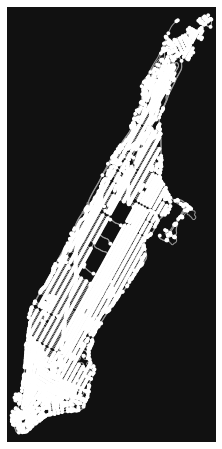

In [36]:
# Import Manhattan network and change node labels to integers
G = ox.graph_from_place('Manhattan, New York, USA', network_type='drive')

# If a node cannot access at least 10% of other nodes, delete it (isolated)
remove_list = []
num_nodes = len(G.nodes)
for node in G.nodes:  
    reach = len(nx.descendants(G, node))
    if reach < num_nodes / 10:
        remove_list.append(node)

for node in remove_list:
    G.remove_node(node)

G = nx.convert_node_labels_to_integers(G, label_attribute='old_node_ID')
ox.plot_graph(G);

Use freeflow travel time as backup in case travel time not available in Uber data

In [37]:
G = ox.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G, precision=1)

### Speed Data
Then import the Uber Movement data and convert to a dictionary with the OSM Way IDs and hour of the day as keys

In [38]:
# Use Uber Movement data to get average speed for all ways during each hour of the average weekday
speed_df = pd.read_csv('Data/nyc_avg_speeds_2019-06.csv') # downloaded from Uber Movement
speed_df = speed_df[['osm_way_id', 'hour', 'speed']]
speed_df.head()

,osm_way_id,hour,speed
0,5029221,0,23.508350
1,5029221,1,24.487867
2,5029221,2,24.330429
3,5029221,3,28.003333
4,5029221,4,24.547684


In [39]:
# Convert to dictionary with way IDs and hour of the day as keys
speed_dict = dict([((t.osm_way_id, t.hour), t.speed) for t in speed_df.itertuples()])
speed_dict[(5029221, 12)]

13.598249999999998

Append the distance / speed of each edge in the graph to the graph properties as travel time

In [40]:
for edge in G.edges:
    edge_obj = G[edge[0]][edge[1]][edge[2]]
    wayid = edge_obj['osmid']
    try:
        speed = speed_dict[wayid] * 1.60934 # Convert from mph to kph
        distance = edge_obj['length'] / 1000 # Convert from m to km
        travel_time = distance / speed * 60 # Convert from hours to minutes
    except:
        travel_time = edge_obj['travel_time'] / 60 # Convert from seconds to minutes
    G[edge[0]][edge[1]][edge[2]]['um_travel_time'] = travel_time

Get shortest paths between all nodes and store the travel time as an array.

In [ ]:
num_nodes = len(G.nodes)
shortest_time = np.zeros((num_nodes, num_nodes))

path_generator = nx.shortest_path_length(G, weight='um_travel_time')
for origin_data in path_generator:
    origin = origin_data[0]
    dist_dict = origin_data[1]
    for destination in dist_dict:
        shortest_time[origin, destination] = dist_dict[destination]

Save for use elsewhere.

In [ ]:
np.save("data/node_travel_times.npy", shortest_time)